# *선형회귀의 가설=선형방정식 
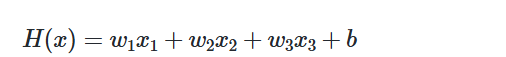  
- w는 가중치, b는 편향

# *비용함수(cost function)
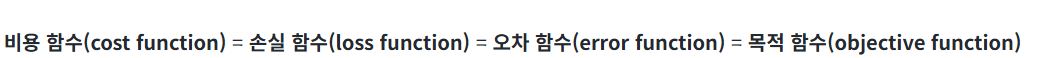
- mse, mae등

# *옵티마이저: 경사하강법으로
- 옵티마이저(Optimizer) 알고리즘: 비용함수를 최소로 하는 w와 b 찾는 알고리즘  
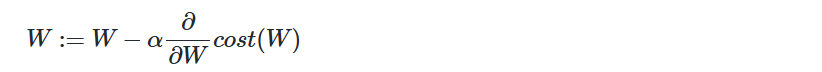
- W는 기울기, alpha는 학습률, 나머지는 미분값

---
# 구현해보기
---

In [1]:
import torch
import torch.nn as nn # 신경망 레이어들과 모델 구조를 정의하는 클래스들 모여있음
import torch.nn.functional as F # 함수들 존재(relu, softmax, cross_entropy등)
import torch.optim as optim # 옵티마이저들(SGD, Adam, AdamW)

# 현재 실습하고 있는 파이썬 코드를 재실행해도 다음에도 같은 결과가 나오도록 랜덤 시드
torch.manual_seed(1)

### 1. 다중 회귀 데이터셋

In [8]:
x_train  =  torch.tensor([[73,  80,  75],   # (5,3)
                          [93,  88,  93], 
                          [89,  91,  80], 
                          [96,  98,  100],   
                          [73,  66,  70]],dtype=torch.float)  
y_train  =  torch.tensor([[152],  [185],  [180],  [196],  [142]],  # (5,1)
                        dtype=torch.float) 

### 2. 가중치와 편향 선언 후 가설 설정
- 특성이 n개면 가중치는 (n,1)로
-  -> 계산하면 (샘플수,1)+b 로 나옴 -> 각 샘플의 스칼라와 y값을 비교

In [6]:
# 가중치와 편향 선언 0으로
W = torch.zeros((3, 1), requires_grad=True) # 학습 중에 미분을 계산해야 한다는 것을 명시하는 설정
b = torch.zeros(1, requires_grad=True) # 값이 변할수 있다는것도 의미함

In [9]:
hypothesis = x_train.matmul(W) + b
hypothesis

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<AddBackward0>)

### 3. cost, optimizer 설정

In [11]:
# cost설정
cost = torch.mean((hypothesis - y_train) ** 2) 
cost

tensor(29661.8008, grad_fn=<MeanBackward0>)

In [12]:
# optimizer 설정
optimizer = optim.SGD([W, b], lr=1e-5) # 가중치,편향넣고 학습률 설정

# gradient를 0으로 초기화
optimizer.zero_grad() 
# 비용 함수를 미분하여 gradient 계산
cost.backward() 
# W와 b를 업데이트
optimizer.step() 
W, b

(tensor([[0.2940],
         [0.2936],
         [0.2902]], requires_grad=True),
 tensor([0.0034], requires_grad=True))

In [13]:
x_train.matmul(W) + b # 새로운 값

tensor([[66.7178],
        [80.1701],
        [76.1025],
        [86.0194],
        [61.1565]], grad_fn=<AddBackward0>)

### 4. 반복

In [14]:
nb_epochs = 20
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    # 편향 b는 브로드 캐스팅되어 각 샘플에 더해집니다.
    hypothesis = x_train.matmul(W) + b

    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)

    # cost로 H(x) 개선
    optimizer.zero_grad() # 누적되므로 계속 초기화 해줘야함
    cost.backward()
    optimizer.step()

    print('Epoch {:4d}/{} hypothesis: {} Cost: {:.6f}'.format(
        epoch, nb_epochs, hypothesis.squeeze().detach(), cost.item()
    ))

Epoch    0/20 hypothesis: tensor([66.7178, 80.1701, 76.1025, 86.0194, 61.1565]) Cost: 9537.694336
Epoch    1/20 hypothesis: tensor([104.5421, 125.6208, 119.2478, 134.7862,  95.8280]) Cost: 3069.590088
Epoch    2/20 hypothesis: tensor([125.9858, 151.3882, 143.7087, 162.4333, 115.4844]) Cost: 990.670898
Epoch    3/20 hypothesis: tensor([138.1429, 165.9963, 157.5768, 178.1071, 126.6283]) Cost: 322.482086
Epoch    4/20 hypothesis: tensor([145.0350, 174.2780, 165.4395, 186.9928, 132.9461]) Cost: 107.717064
Epoch    5/20 hypothesis: tensor([148.9423, 178.9730, 169.8976, 192.0301, 136.5279]) Cost: 38.687496
Epoch    6/20 hypothesis: tensor([151.1574, 181.6346, 172.4254, 194.8856, 138.5585]) Cost: 16.499043
Epoch    7/20 hypothesis: tensor([152.4131, 183.1435, 173.8590, 196.5043, 139.7097]) Cost: 9.365656
Epoch    8/20 hypothesis: tensor([153.1250, 183.9988, 174.6723, 197.4217, 140.3625]) Cost: 7.071114
Epoch    9/20 hypothesis: tensor([153.5285, 184.4835, 175.1338, 197.9415, 140.7325]) Cost: 

### 5. 예측하기

In [15]:
# 임의의 입력 값에 대한 예측
with torch.no_grad():
    new_input = torch.FloatTensor([[75, 85, 72]])  # 예측하고 싶은 임의의 입력
    prediction = new_input.matmul(W) + b
    print('Predicted value for input {}: {}'.format(new_input.squeeze().tolist(), prediction.item()))

Predicted value for input [75.0, 85.0, 72.0]: 156.80615234375


---
# nn.module로 구현하기
---

### 1. 데이터셋

In [2]:
x_train  =  torch.tensor([[73,  80,  75],   # (5,3)
                          [93,  88,  93], 
                          [89,  91,  80], 
                          [96,  98,  100],   
                          [73,  66,  70]],dtype=torch.float)  
y_train  =  torch.tensor([[152],  [185],  [180],  [196],  [142]],  # (5,1)
                        dtype=torch.float) 

### 2. nn.linear(in,out)로 층 구현, F.relu로 활성화 함수
- F.relu는 함수, nn.ReLU는 층

In [3]:
# 특성개수,뉴런수
fc1 = nn.Linear(3, 4)
fc2 = nn.Linear(4, 2)
fc3 = nn.Linear(2, 1)

# 모델 만들기
def model(x):
    x = F.relu(fc1(x))
    x = F.relu(fc2(x))
    x = fc3(x)
    return x

'''
이렇게도 가능
model = nn.Sequential(
    nn.Linear(3, 4),
    nn.ReLU(),
    nn.Linear(4, 2),
    nn.ReLU(),
    nn.Linear(2, 1),
    nn.Sigmoid()  # 이진 분류용
)
'''

### 3. optimizer와 cost

In [ ]:
# cost: F함수 이용
cost = F.mse_loss(prediction, y_train)

# optimizer
optimizer = torch.optim.Adam(
    list(fc1.parameters()) + list(fc2.parameters()) + list(fc3.parameters()), #층별로 넣어줘야함
    lr=0.01)

### 4. 반복해서 학습하기

In [5]:
nb_epochs = 100
for epoch in range(nb_epochs+1):

    # H(x) 계산
    prediction = model(x_train)
    # model(x_train)은 model.forward(x_train)와 동일함.

    # cost 계산
    cost = F.mse_loss(prediction, y_train) # <== 파이토치에서 제공하는 평균 제곱 오차 함수

    optimizer.zero_grad() # gradient를 0으로 초기화
    cost.backward() # 비용 함수를 미분하여 gradient 계산
    optimizer.step() # W와 b를 업데이트

    if epoch % 20 == 0:
    # 100번마다 로그 출력
      print('Epoch {:4d}/{} Cost: {:.6f}'.format(
          epoch, nb_epochs, cost.item()
      ))

Epoch    0/100 Cost: 28341.099609
Epoch   20/100 Cost: 14652.640625
Epoch   40/100 Cost: 217.747101
Epoch   60/100 Cost: 42.448196
Epoch   80/100 Cost: 12.212589
Epoch  100/100 Cost: 10.086611


### 5. 예측

In [7]:
new_var =  torch.tensor([[73, 80, 75]],dtype=torch.float) 
pred_y = model(new_var) 
print("훈련 후 입력이 73, 80, 75일 때의 예측값 :", pred_y) 

훈련 후 입력이 73, 80, 75일 때의 예측값 : tensor([[153.1853]], grad_fn=<AddmmBackward0>)


---
# 클래스로 구현하기(옵티마이저 간단화)
---

### nn.module을 상속 !!!

In [8]:
class mylinearmodel(nn.Module):
    def __init__(self):
        super(mylinearmodel, self).__init__()

        # Linear layers
        self.fc1 = nn.Linear(3, 4)   # input 3 → hidden 4
        self.fc2 = nn.Linear(4, 2)   # hidden 4 → hidden 2
        self.fc3 = nn.Linear(2, 1)   # hidden 2 → output 1

    def forward(self, x):
        x = F.relu(self.fc1(x))     # activation after first layer
        x = F.relu(self.fc2(x))     # activation after second layer
        x = self.fc3(x)             # final layer (no activation)
        return x

In [11]:
# 모델 생성
model=mylinearmodel()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [13]:
nb_epochs = 100
for epoch in range(nb_epochs+1):
    prediction = model(x_train)
    cost = F.mse_loss(prediction, y_train) # <== 파이토치에서 제공하는 평균 제곱 오차 함수
    optimizer.zero_grad() # gradient를 0으로 초기화
    cost.backward() # 비용 함수를 미분하여 gradient 계산
    optimizer.step() # W와 b를 업데이트

    if epoch % 20 == 0:
    # 100번마다 로그 출력
      print('Epoch {:4d}/{} Cost: {:.6f}'.format(
          epoch, nb_epochs, cost.item()
      ))

Epoch    0/100 Cost: 30686.556641
Epoch   20/100 Cost: 18455.041016
Epoch   40/100 Cost: 1257.602295
Epoch   60/100 Cost: 333.059479
Epoch   80/100 Cost: 57.971325
Epoch  100/100 Cost: 9.894424


---
# 배치 정해서 넣기
---

In [14]:
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

In [15]:
# 하나로 묶기
dataset = TensorDataset(x_train, y_train)

# 배치크기 정하고 섞기
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [18]:
nb_epochs = 3
for epoch in range(nb_epochs + 1):
  for a,b in enumerate(dataloader): # a에 id b에 x,y샘플들
    x_train, y_train = b
    
    prediction = model(x_train)
    cost = F.mse_loss(prediction, y_train)
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format(
        epoch, nb_epochs, a+1, len(dataloader),
        cost.item()
        ))

Epoch    0/3 Batch 1/3 Cost: 3.099932
Epoch    0/3 Batch 2/3 Cost: 3.874692
Epoch    0/3 Batch 3/3 Cost: 0.055455
Epoch    1/3 Batch 1/3 Cost: 2.418153
Epoch    1/3 Batch 2/3 Cost: 2.226068
Epoch    1/3 Batch 3/3 Cost: 5.377409
Epoch    2/3 Batch 1/3 Cost: 0.019044
Epoch    2/3 Batch 2/3 Cost: 4.777405
Epoch    2/3 Batch 3/3 Cost: 4.884939
Epoch    3/3 Batch 1/3 Cost: 4.293637
Epoch    3/3 Batch 2/3 Cost: 2.699415
Epoch    3/3 Batch 3/3 Cost: 0.009418


---
---
---
---
---
# 분류

## 1. 이진분류
- 활성화 함수로 sigmoid와 손실함수로 BCELoss사용

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [24]:
x_data = [[1, 2], [2, 3], [3, 1], [4, 3], [5, 3], [6, 2]]
y_data = [[0], [0], [0], [1], [1], [1]]
x_train = torch.tensor(x_data,dtype=torch.float)
y_train = torch.tensor(y_data,dtype=torch.float)
x_train.shape

torch.Size([6, 2])

In [25]:
model = nn.Sequential(
   nn.Linear(2, 4), # input_dim = 2, output_dim = 1
   nn.ReLU(), # 중간층의 활성화
   nn.Linear(4,1),
   nn.Sigmoid() # 출력층에는 sigmoid
)

In [26]:
# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=0.1)

# cost설정
criterion=nn.BCELoss()

nb_epochs = 100
for epoch in range(nb_epochs + 1):
    hypothesis = model(x_train)
    cost = criterion(hypothesis, y_train)
# BCEWithLogitsLoss 요즘 많이 쓰고 이거 쓸려면 마지막 층에 sigmoid층 제거해주면 됨(그냥 logits값 나오게)

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 20번마다 로그 출력
    if epoch % 10 == 0:
        prediction = hypothesis >= torch.FloatTensor([0.5]) # 예측값이 0.5를 넘으면 True로 간주
        correct_prediction = prediction.float() == y_train # 실제값과 일치하는 경우만 True로 간주
        accuracy = correct_prediction.sum().item() / len(correct_prediction) # 정확도를 계산
        print('Epoch {:4d}/{} Cost: {:.6f} Accuracy {:2.2f}%'.format( # 각 에포크마다 정확도를 출력
            epoch, nb_epochs, cost.item(), accuracy * 100,
        ))

Epoch    0/100 Cost: 1.223134 Accuracy 50.00%
Epoch   10/100 Cost: 0.524268 Accuracy 83.33%
Epoch   20/100 Cost: 0.442887 Accuracy 83.33%
Epoch   30/100 Cost: 0.391773 Accuracy 83.33%
Epoch   40/100 Cost: 0.353067 Accuracy 83.33%
Epoch   50/100 Cost: 0.322972 Accuracy 83.33%
Epoch   60/100 Cost: 0.298525 Accuracy 83.33%
Epoch   70/100 Cost: 0.277839 Accuracy 83.33%
Epoch   80/100 Cost: 0.257937 Accuracy 83.33%
Epoch   90/100 Cost: 0.240060 Accuracy 83.33%
Epoch  100/100 Cost: 0.222663 Accuracy 83.33%


### 예측

In [28]:
model(x_train) # 0.5보다 크면 클래스 1

tensor([[0.0517],
        [0.1028],
        [0.5220],
        [0.7743],
        [0.8925],
        [0.9463]], grad_fn=<SigmoidBackward0>)

### 파라미터

In [30]:
print(list(model.parameters()))

[Parameter containing:
tensor([[-0.2195,  0.2381],
        [ 0.6391,  0.3428],
        [-0.7886,  1.0457],
        [ 0.5006,  0.5250]], requires_grad=True), Parameter containing:
tensor([ 0.8958, -1.1076, -0.0180,  0.6821], requires_grad=True), Parameter containing:
tensor([[-0.8068,  1.2746, -1.0593, -0.2169]], requires_grad=True), Parameter containing:
tensor([-0.4097], requires_grad=True)]


## *클래스 사용 버전

In [31]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 4)   # input_dim = 2 → hidden_dim = 4
        self.fc2 = nn.Linear(4, 1)   # hidden_dim = 4 → output_dim = 1
        self.sigmoid = nn.Sigmoid() # 출력층 활성화

    def forward(self, x):
        x = F.relu(self.fc1(x))      # 중간층 활성화
        x = self.fc2(x)
        x = self.sigmoid(x)          # 출력층 sigmoid
        return x

model=BinaryClassifier()
# 이후 반복해서 학습

## 2. 다중분류
- softmax와 CrossEntropyLoss사용
- 정답은 주로 정수인코딩 사용 !!!!
- 원핫인코딩은 권장X

In [39]:
x_train = [[1, 2, 1, 1],
           [2, 1, 3, 2],
           [3, 1, 3, 4],
           [4, 1, 5, 5],
           [1, 7, 5, 5],
           [1, 2, 5, 6],
           [1, 6, 6, 6],
           [1, 7, 7, 7]]
y_train = [2, 2, 2, 1, 1, 1, 0, 0]
x_train = torch.tensor(x_train,dtype=torch.float)
y_train = torch.tensor(y_train) #nn.CrossEntropyLoss()는 정답 라벨(y_train)이 정수 인덱스여야 함
x_train.shape

torch.Size([8, 4])

In [40]:
# softmax층 필요x !!!!
model = nn.Sequential(
    nn.Linear(4, 4),     # input_dim = 4 → hidden_dim = 4
    nn.ReLU(),
    nn.Linear(4, 3)      # hidden_dim = 4 → output_dim = 3 (3개 클래스)
    # ❌ Softmax 넣지 마세요! CrossEntropyLoss가 내부적으로 처리함
)

In [42]:
# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=0.1)

# cost설정
criterion = nn.CrossEntropyLoss()

nb_epochs = 500
for epoch in range(nb_epochs + 1):

    prediction = model(x_train)
    cost = criterion(prediction, y_train)

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 20번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/500 Cost: 0.452129
Epoch  100/500 Cost: 0.318565
Epoch  200/500 Cost: 0.199543
Epoch  300/500 Cost: 0.132486
Epoch  400/500 Cost: 0.094908
Epoch  500/500 Cost: 0.069089


## *class버전

In [43]:
# 직접 숫자넣거나 객체 만들때 넣을수도 있음
class MultiClassClassifier(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=4, num_classes=3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Softmax 없이 로짓 출력
        return x

model=MultiClassClassifier()

## 평가,검증점수 확인 방법

In [ ]:
# 함수 생성
def evaluate(model, criterion, data_loader, device):
    model.eval()  # 평가 모드로 전환
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad(): # 가중치 계산을 끄겠다-> 평가만
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item() * x_batch.size(0)  # 배치 크기 곱해서 합산

            preds = torch.argmax(outputs, dim=1)
            total_correct += (preds == y_batch).sum().item()
            total_samples += x_batch.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    return avg_loss, accuracy

In [ ]:
# 사용법

# device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
criterion = nn.CrossEntropyLoss()

# 예: DataLoader가 준비되어 있다고 가정
val_loss, val_acc = evaluate(model, criterion, val_loader, device)
print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc*100:.2f}%")

## model.eval() 후에는 학습 모드(model.train())로 반드시 복귀해야 함